<a href="https://colab.research.google.com/github/Patric/fkd-gs/blob/master/notebooks/FakeNewsDetectionGraphSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake news detection using graph solutions

This notebook is a walkthrough feature selection process and machine learning effects of Fake news detection using graph solution Master's Thesis.

# Code formatting
Use !black command once to format the code, then use F5 and then save. Uncomment when needed

In [1]:
# ! pip install black[jupyter]

In [2]:
# !black /content/drive/MyDrive/ColabNotebooks/FakeNewsDetectionGraphSolutions.ipynb

# Dataset loading

## Mount google drive with processed features and define dataset paths

In [85]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libs for operating on datasets

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from enum import Enum

### Set datasets paths variables and map column names to features

Warning!!! These are Colab based paths. As for now data should be saved to your google drive from https://drive.google.com/drive/folders/1HOEIyiiFBALoqrHN5Jh8RczkvMIgUVyH?usp=sharing
 Paths should be adjusted accordingly

In [87]:
# variable should be adjusted according to your google drive TODO: figure out how to bond datasets more simply
features_directory_path = "/content/drive/MyDrive/FakeNewsDetectonColabNotebooks/resources/features"

politifact_more_than_1_relation_path = (
    f"{features_directory_path}/politifact_more_than_1_relation/"
)
politifact_all_path = f"{features_directory_path}/politifact_all/"
gossipcop_path = f"{features_directory_path}/gossipcop/"

e13_followers_path = f"{features_directory_path}/MIB/E13/"
fsf_followers_path = f"{features_directory_path}/MIB/FSF/"
int_followers_path = f"{features_directory_path}/MIB/INT/"
twt_followers_path = f"{features_directory_path}/MIB/TWT/"
tfp_followers_path = f"{features_directory_path}/MIB/TFP/"

In [88]:
features_files_names = [
    "eigenvector_to_label.csv",
    "harmonic_closeness_to_label.csv",
    "hits_to_label.csv",
    "betweenness_to_label.csv",
    "closeness_to_label.csv",
    "page_rank_to_label.csv",
    "article_rank_to_label.csv",
    "degree_to_label.csv",
]

class FeatureColumnName(Enum):
  EIGENVECTOR = 'eigenvector_score'
  HARMONIC_CLOSENESS = 'harmonic_closeness_centrality'
  CLOSENESS = 'closeness_score'
  HITS_HUB = 'hits_hub'
  HITS_AUTH = 'hits_auth'
  BETWEENNESS = 'betweenness_score'
  PAGE_RANK = 'page_rank_score'
  ARTICLE_RANK = 'article_rank_score'
  OUT_DEGREE = 'outDegree'
  IN_DEGREE = 'inDegree'
  DEGREE = 'degree'

## Define util functions

In [89]:
def get_data_frame(*paths):
    paths = list(sum(paths, []))
    dfs = list(map(lambda path: pd.read_csv(path), paths))
    df = pd.concat(dfs, join="outer", axis=1)
    df = df.loc[:, ~df.columns.duplicated()].copy()
    return df


def get_feature_full_path(data_set_path, feature_data):
    return f"{data_set_path}{feature_data}"


def get_features_paths(data_set_path, features_files):
    return list(
        map(
            lambda feature_file: get_feature_full_path(data_set_path, feature_file),
            features_files,
        )
    )

In [90]:
# split into dependend and independent variables
def split_into_X_y(data_frame, dependent_variables_list, independend_variable):
  X = data_frame[dependent_variables_list]
  y = data_frame[independend_variable]

  return X, y

## Convert datasets to Pandas DataFrames

In [91]:
paths_array = [e13_followers_path, fsf_followers_path, int_followers_path, twt_followers_path, tfp_followers_path]
mib_combined = list(map(lambda dataset_path: get_data_frame(get_features_paths(dataset_path, features_files_names)), paths_array))
dfs_mib_combined = pd.concat(mib_combined)

In [92]:
df_politifact = get_data_frame(get_features_paths(politifact_all_path, features_files_names))
df_politifact_more_than_1_relation = get_data_frame(get_features_paths(politifact_more_than_1_relation_path, features_files_names))

df_gossipcop = get_data_frame(get_features_paths(gossipcop_path, features_files_names))

df_fake_news_net_skeleton_combined = pd.concat([df_politifact, df_gossipcop])

In [93]:
datasets = {
    'politifact': df_politifact,
    'gossipcop': df_gossipcop,
    # fake_news_skeleton_combined = politifact + gossipcop
    'fake_news_skeleton_combined': df_fake_news_net_skeleton_combined,
    'mib_combined': dfs_mib_combined
}

# Feature selection


## Set prerequisites

### Import libs for feature selection

In [103]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from IPython.display import display
import seaborn as sns

### Define feature selection **functions**

In [231]:
def select_features_chi2(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=chi2, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  results = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i])
    row = []
    row.append(fs.scores_[i])
    if hasattr(fs, 'pvalues_'):
      row.append(fs.pvalues_[i])
      results.append([fs.scores_[i], fs.pvalues_[i]])
                
  return pd.DataFrame(results, columns=['Chi2 scores', 'Chi2 pvalues'], index=feature_names)

In [248]:
def select_features_f(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=f_classif, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  results = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i]) 
    results.append([fs.scores_[i], fs.pvalues_[i]])
                
  return pd.DataFrame(results, columns=['F-test scores', 'F-test pvalues'], index=feature_names)

In [229]:
def select_features_mutual_info(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=mutual_info_classif, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  scores = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i]) 
    scores.append([fs.scores_[i]])

  return pd.DataFrame(scores, columns=['Mutual info scores'], index=feature_names)

In [228]:
def select_features_r(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=r_regression, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  scores = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i])
    scores.append([fs.scores_[i]])

  return pd.DataFrame(scores, columns=['Pearson scores'], index=feature_names)

In [237]:
def tree_classifier(X, y):
  clf = ExtraTreesClassifier(n_estimators=50)
  clf = clf.fit(X, y)
  feature_names = []
  scores = []
  for i in range(len(clf.feature_importances_)):
    feature_names.append(clf.feature_names_in_[i])
    scores.append([clf.feature_importances_[i]])

  return pd.DataFrame(scores, columns=['Tree classifier importances'], index=feature_names)

In [201]:
def plot_pearson_corr_matrix(data_frame, name):
  corr = data_frame.corr(method='pearson')
  plt.figure(figsize=(20, 10))
  # Increase the size of the 
  heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
  heatmap.set_title(f'{name} pearson correlation Heatmap', fontdict={'fontsize':12}, pad=12)
  plt.show()

In [234]:
def test_linear_regression_model(X_train, y_train, X_test, y_test):
  linreg=LinearRegression()
  linreg.fit(X_train,y_train)
  y_pred=linreg.predict(X_test)
  Accuracy=r2_score(y_test,y_pred)*100
  print(" Accuracy of the model is %.2f" %Accuracy)
  plt.scatter(y_test,y_pred)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()
  sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')
  plt.show()

In [239]:
def test_feature_dependency_for_dataset(df, df_name='Data frame'):
  features_included = [
          FeatureColumnName.EIGENVECTOR.value,
          FeatureColumnName.HARMONIC_CLOSENESS.value,
          FeatureColumnName.HITS_HUB.value,
          FeatureColumnName.HITS_AUTH.value,
          FeatureColumnName.BETWEENNESS.value,
          FeatureColumnName.CLOSENESS.value,
          FeatureColumnName.PAGE_RANK.value,
          FeatureColumnName.ARTICLE_RANK.value,
          FeatureColumnName.OUT_DEGREE.value,
          FeatureColumnName.IN_DEGREE.value,
          FeatureColumnName.DEGREE.value
          ]
  
  label_column_name = 'user.label'
  X, y = split_into_X_y(df, features_included, label_column_name)

  plot_pearson_corr_matrix(df, df_name)
  df_mi = select_features_mutual_info(X, y)
  df_f = select_features_f(X, y)
  df_chi2 = select_features_chi2(X, y)
  df_r = select_features_r(X, y)
  df_t =  tree_classifier(X, y)
  df_output = pd.concat([df_mi, df_f, df_chi2, df_r, df_t], axis=1)

  display(df_output)

  print(f'Linear regression of features: {features_included}')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  test_linear_regression_model(X_train, y_train, X_test, y_test)

## Test feature dependency

In [242]:
datasets_enriched = datasets.copy()
datasets_enriched['mib_combined_at_least_1_degree'] = datasets['mib_combined'].query('degree != 1')

### Select gossipcop features

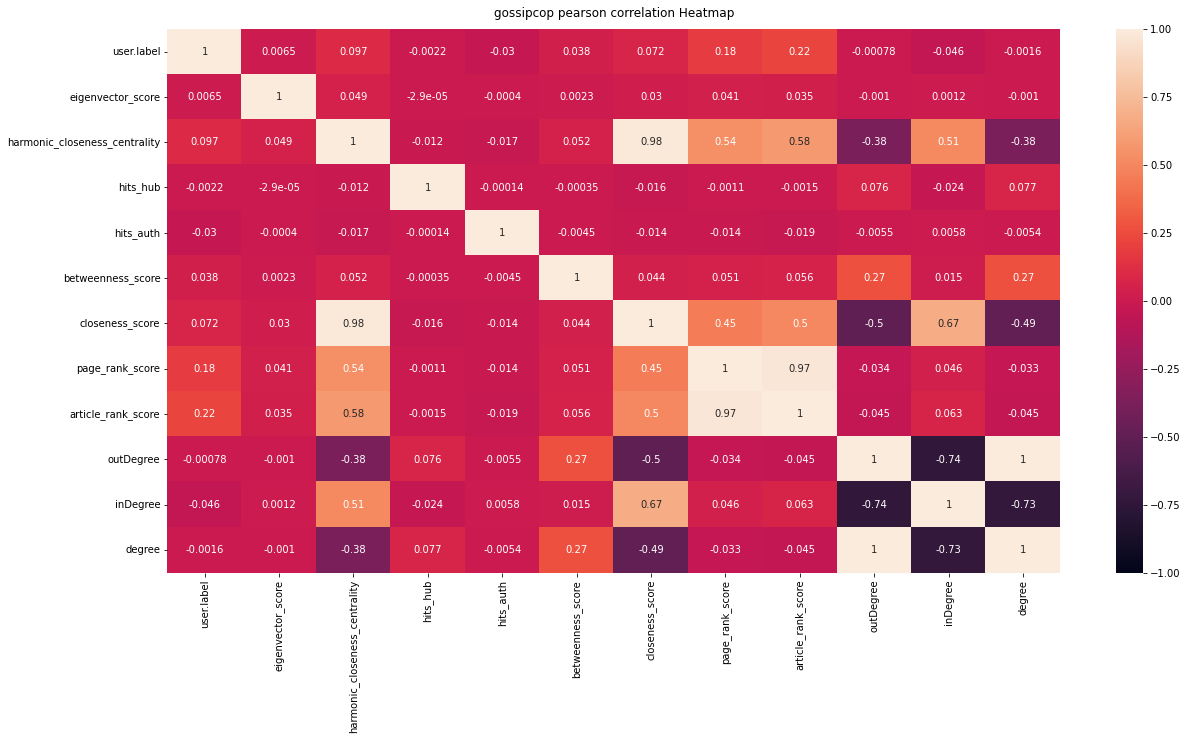

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.012,13.190,0.000,2.559,0.110,0.006,0.002
harmonic_closeness_centrality,0.011,2976.466,0.000,0.001,0.979,0.097,0.022
hits_hub,0.000,1.512,0.219,0.844,0.358,-0.002,0.000
hits_auth,0.012,282.384,0.000,11.521,0.001,-0.030,0.015
betweenness_score,0.009,445.080,0.000,12701.546,0.000,0.038,0.017
closeness_score,0.011,1637.603,0.000,0.000,0.988,0.072,0.028
page_rank_score,0.207,10651.680,0.000,69.852,0.000,0.181,0.406
article_rank_score,0.208,16389.056,0.000,23.628,0.000,0.223,0.457
outDegree,0.013,0.191,0.662,11.358,0.001,-0.001,0.022
inDegree,0.042,654.636,0.000,11.358,0.001,-0.046,0.003


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 7.91


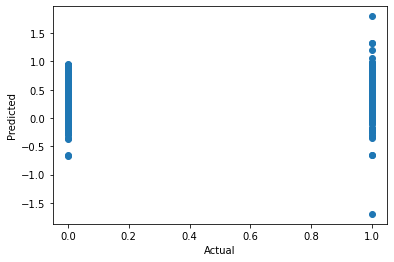

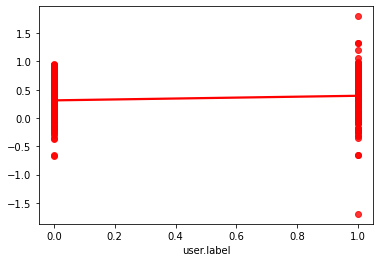

In [243]:
name = 'gossipcop'
test_feature_dependency_for_dataset(datasets_enriched[name], name)

### Select politifact features

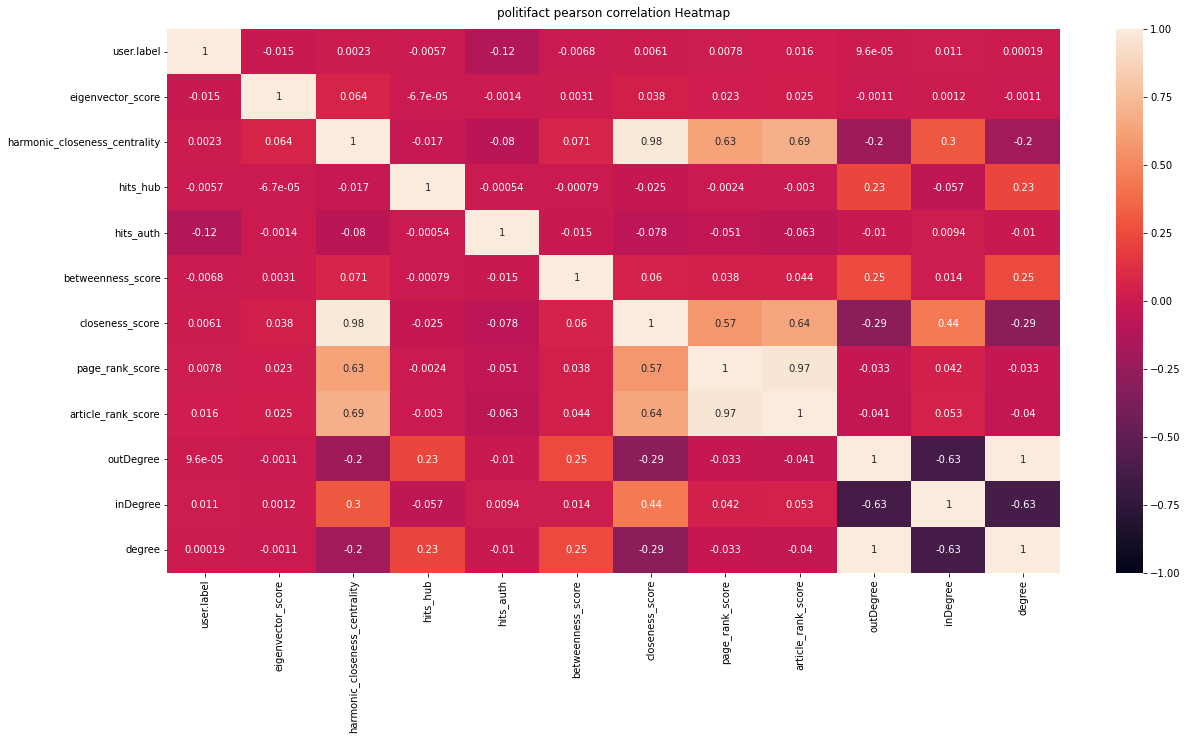

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.001,8.667,0.003,3.210,0.073,-0.015,0.001
harmonic_closeness_centrality,0.000,0.211,0.646,0.000,0.999,0.002,0.005
hits_hub,0.002,1.315,0.252,1.295,0.255,-0.006,0.000
hits_auth,0.025,607.285,0.000,27.472,0.000,-0.121,0.028
betweenness_score,0.002,1.873,0.171,74.700,0.000,-0.007,0.013
closeness_score,0.003,1.532,0.216,0.000,0.999,0.006,0.005
page_rank_score,0.563,2.527,0.112,0.037,0.847,0.008,0.461
article_rank_score,0.565,10.647,0.001,0.034,0.854,0.016,0.470
outDegree,0.004,0.000,0.984,0.036,0.850,0.000,0.008
inDegree,0.007,4.707,0.030,0.036,0.850,0.011,0.000


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 1.57


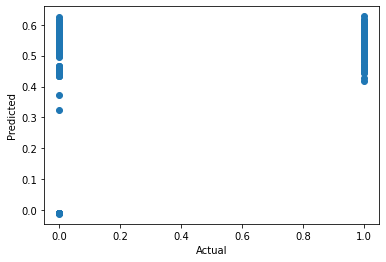

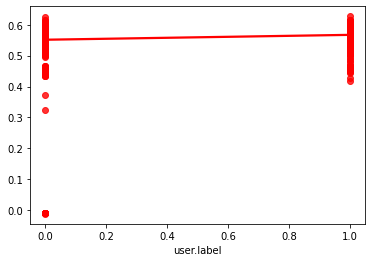

In [244]:
name = 'politifact'
test_feature_dependency_for_dataset(datasets_enriched[name], name)

### Select gossipcop + politifact features

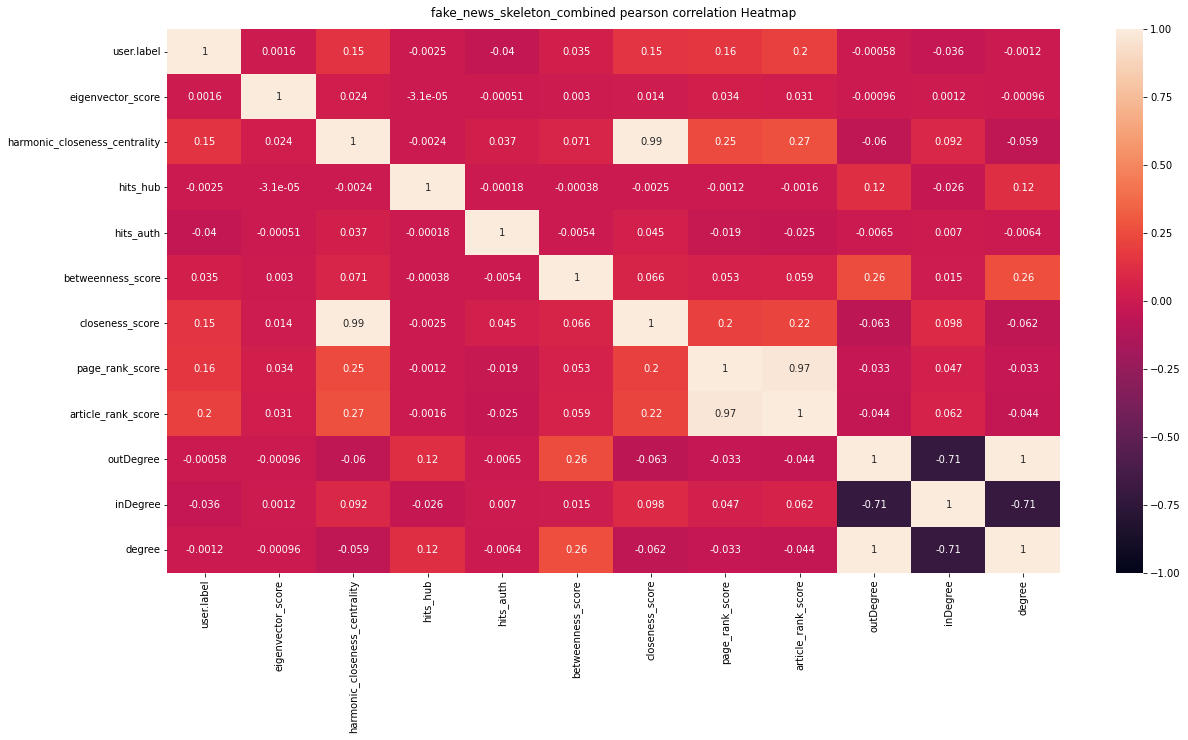

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.019,0.929,0.335,0.237,0.627,0.002,0.003
harmonic_closeness_centrality,0.020,7925.474,0.000,0.101,0.750,0.148,0.042
hits_hub,0.000,2.148,0.143,1.530,0.216,-0.002,0.000
hits_auth,0.012,583.671,0.000,25.271,0.000,-0.040,0.015
betweenness_score,0.009,438.670,0.000,13913.119,0.000,0.035,0.016
closeness_score,0.019,8073.976,0.000,0.086,0.770,0.149,0.050
page_rank_score,0.225,9778.541,0.000,74.900,0.000,0.164,0.400
article_rank_score,0.259,14958.180,0.000,25.026,0.000,0.201,0.434
outDegree,0.012,0.121,0.728,7.679,0.006,-0.001,0.018
inDegree,0.047,472.832,0.000,7.679,0.006,-0.036,0.003


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 8.22


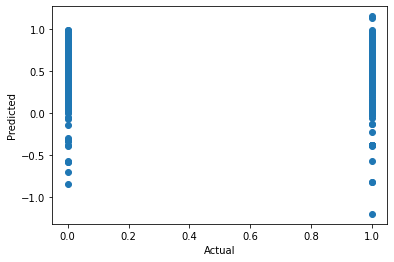

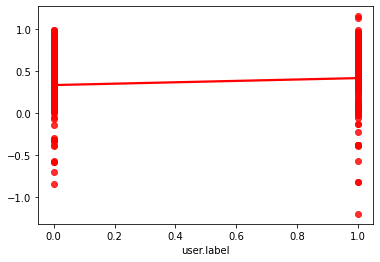

In [245]:
# politifact + gossipcop
name = 'fake_news_skeleton_combined'
test_feature_dependency_for_dataset(datasets_enriched[name], name)

### Select MIB combined user followers network features

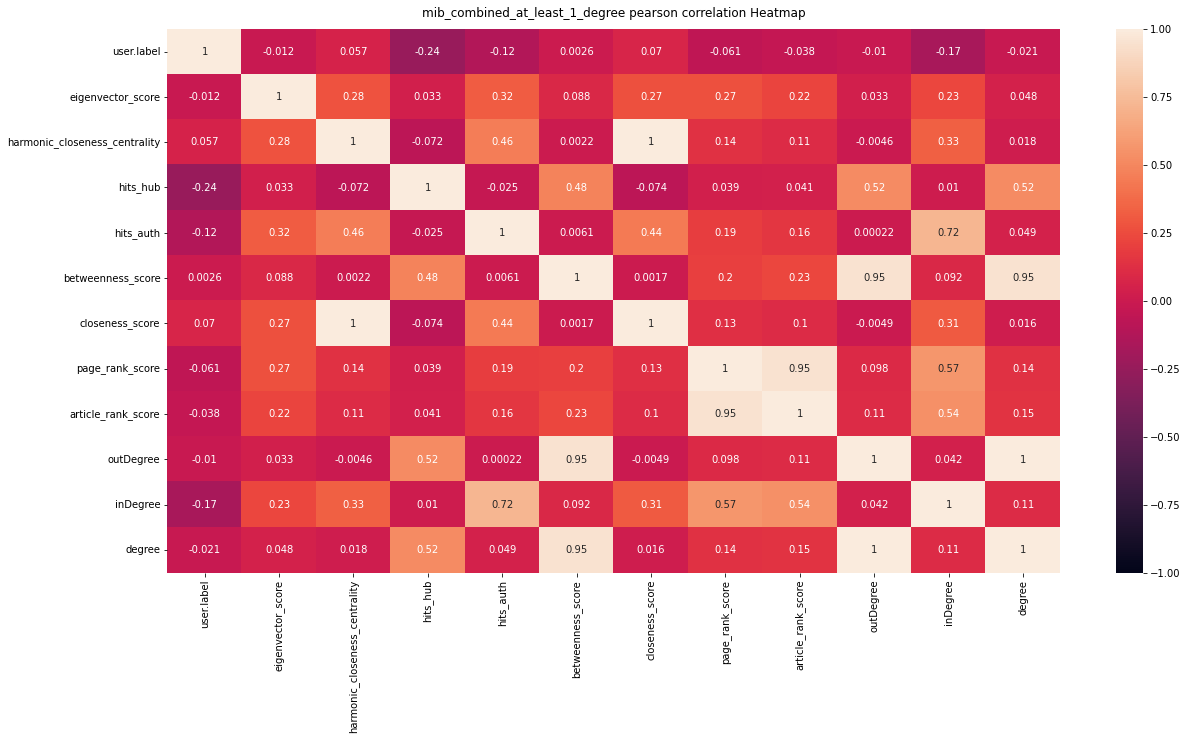

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.242,55.351,0.000,0.544,0.461,-0.012,0.008
harmonic_closeness_centrality,0.311,1292.338,0.000,38.358,0.000,0.057,0.396
hits_hub,0.287,23645.622,0.000,857.251,0.000,-0.238,0.159
hits_auth,0.297,5688.035,0.000,56.879,0.000,-0.119,0.036
betweenness_score,0.007,2.751,0.097,5555298808.820,0.000,0.003,0.000
closeness_score,0.311,1961.046,0.000,53.817,0.000,0.070,0.365
page_rank_score,0.275,1467.374,0.000,23523.720,0.000,-0.061,0.002
article_rank_score,0.261,585.618,0.000,979.537,0.000,-0.038,0.000
outDegree,0.226,40.842,0.000,2773231.171,0.000,-0.010,0.008
inDegree,0.263,11196.203,0.000,4295413.567,0.000,-0.166,0.017


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 19.86


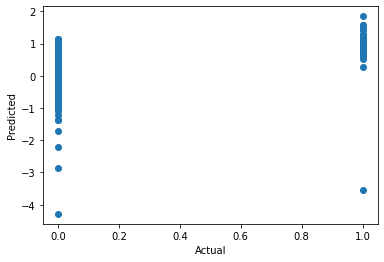

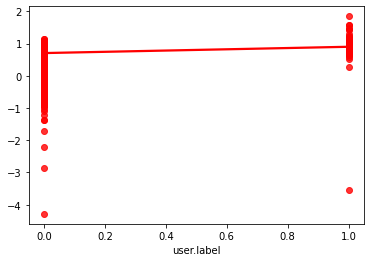

In [246]:
name = 'mib_combined_at_least_1_degree'
test_feature_dependency_for_dataset(datasets_enriched[name], name)

### Test all at once

In [247]:
# for dataset_name in datasets_enriched:
#   print(f'Testing feature dependency for: {dataset_name}')
#   test_feature_dependency_for_dataset(datasets_enriched[dataset_name], dataset_name)

# Classifiers testing

## Set prerequisites

### Import libs for classifiers *testing*

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold

### Define test classifiers functions

In [10]:
def test_classfiers(classifiers, X_train, X_test, y_train, y_test):
  log_cols = ["Classifier", "Accuracy", "Log Loss"]
  log = pd.DataFrame(columns=log_cols)

  for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("=" * 30)
    print(name)

    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc * 100, ll]], columns=log_cols)
    log = log.append(log_entry)

  print("=" * 30)

## Test classifiers for Politifact with best features

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(df_fake_news_net_skeleton_combined, features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

### Test classifiers for Gossipcop best features

### Test classifiers for Politifact and Gossipcop combined best features

### Test classifiers for MIB combined best features

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(df_fake_news_net_skeleton_combined, features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 77.9889%
Log Loss: 3.0770044259677074


In [ ]:
classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

# Markup helper TODO: delete


Markdown | Preview
--- | ---
`**bold text**` | **bold text**
`*italicized text*` or `_italicized text_` | *italicized text*
`` `Monospace` `` | `Monospace`
`~~strikethrough~~` | ~~strikethrough~~
`[A link](https://www.google.com)` | [A link](https://www.google.com)
`![An image](https://www.google.com/images/rss.png)` | ![An image](https://www.google.com/images/rss.png)


---
Headings are rendered as titles.

```markdown
# Section 1
# Section 2
## Sub-section under Section 2
### Sub-section under the sub-section under Section 2
# Section 3
```

# Section 1
# Section 2
## Sub-section under Section 2
### Sub-section under the sub-section under Section 2
# Section 3

The table of contents, available on the left side of Colab, is populated using at most one section title from each text cell.

---

```markdown
>One level of indentation
```

>One level of indentation


```markdown
>>Two levels of indentation
```

>>Two levels of indentation

---

Code blocks

````
```python
print("a")
```
````

```python
print("a")
```

---

Ordered lists:
```markdown
1. One
1. Two
1. Three
```
1. One
1. Two
1. Three

---

Unordered lists:
```markdown
* One
* Two
* Three
```
* One
* Two
* Three

---

Equations:

```markdown
$y=x^2$

$e^{i\pi} + 1 = 0$

$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$

$\frac{n!}{k!(n-k)!} = {n \choose k}$

$A_{m,n} =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{m,1} & a_{m,2} & \cdots & a_{m,n}
 \end{pmatrix}$
```

$y=x^2$

$e^{i\pi} + 1 = 0$

$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$

$\frac{n!}{k!(n-k)!} = {n \choose k}$

$A_{m,n} =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{m,1} & a_{m,2} & \cdots & a_{m,n}
 \end{pmatrix}$


 ---

Tables:
```markdown
First column name  | Second column name 
-------------------|------------------
Row 1, Col 1       | Row 1, Col 2 
Row 2, Col 1       | Row 2, Col 2 

```

First column name  | Second column name 
-------------------|------------------
Row 1, Col 1       | Row 1, Col 2 
Row 2, Col 1       | Row 2, Col 2 

---

Horizontal rules:
```markdown
---
```

---




## Differences between Colab Markdown and other Markdown dialects

Colab uses [marked.js](https://github.com/chjj/marked) and so is similar but not quite identical to the Markdown used by Jupyter and Github.

Colab supports (MathJax) $\LaTeX$ equations like Jupyter, but does not allow HTML tags in the Markdown. Colab does not support some GitHub additions like emojis and to-do checkboxes.

If HTML must be included in a Colab notebook, see the [%%html magic](/notebooks/basic_features_overview.ipynb#scrollTo=qM4myQGfQboQ).

## Useful references

* [Github Markdown basics](https://help.github.com/articles/markdown-basics/)
* [Github flavored Markdown](https://help.github.com/articles/github-flavored-markdown/)
* [Original Markdown spec: Syntax](http://daringfireball.net/projects/markdown/syntax)
* [Original Markdown spec: Basics](http://daringfireball.net/projects/markdown/basics)
* [marked.js library used by Colab](https://github.com/chjj/marked)
* [LaTex mathematics for equations](https://en.wikibooks.org/wiki/LaTeX/Mathematics)